In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import analysis.motif_util as motif_util
import analysis.motif_compare as motif_compare
import plot.plot_motifs as plot_motifs
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pcolors
import matplotlib.font_manager as font_manager
import tqdm.notebook

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

### Define paths and constants

In [3]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [4]:
datasets = [
    "CTCF (HepG2)", "FOXA1 (HepG2)", "DNase (HepG2)", "DNase (HL-60)", "DNase (K562)"
]

In [5]:
datasets_sanit = {
    dataset_key : dataset_key.replace("/", "_").replace(" ", "").replace("(", "_").replace(")", "").lower()
    for dataset_key in datasets
}

In [6]:
relevant_motifs = {
    "CTCF (HepG2)": ["CTCF"],
    "FOXA1 (HepG2)": ["FOX", "HNF4", "CEBP"],
    "MAX (HepG2)": ["MAX"],
    "DNase (HepG2)": ["HNF", "TEAD", "CTCF", "FOX", "CEBP", "FOS::JUN"],
    "DNase (HL-60)": ["RUNX", "CTCF", "FOX", "CEBP", "SPI1"],
    "DNase (K562)": ["FOSL2::JUN", "CTCF", "GATA"]
}

In [7]:
known_motifs_path = "/home/tsenga5/mechint_regnet/data/databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_sanitname.txt"

In [8]:
motifs_cache_path = "/home/tsenga5/mechint_regnet/results/motifs/"

In [9]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/true_experimental_motifs"
os.makedirs(figures_out_path, exist_ok=True)

### Import ARGMINN motifs and all true motifs

In [10]:
# For each dataset, create a data loader and use it to compute PFMs and activation frequencies
mechint_pfms = {}
mechint_pfms_used = {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    cache_dir = os.path.join(
        motifs_cache_path,
        dataset_key.replace("/", "-").replace(" ", "").replace("(", "_").replace(")", "").lower()
    )

    mechint_pfms_path = os.path.join(cache_dir, "mechint_net.npz")
    mechint_pfms[dataset_key] = np.load(mechint_pfms_path)["pfms"]
    mechint_pfms_used[dataset_key] = [np.sum(pfm) > 0 for pfm in mechint_pfms[dataset_key]]

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
true_pfms = motif_util.import_meme_motifs(known_motifs_path)

### Match ARGMINN motifs to relevant motifs

In [12]:
# Limit the set of true PFMs to only those matching relevant motifs
relevant_pfms = {}
for dataset_key in datasets:
    # For each dataset, create dictionary mapping relevant motif keys to actual true motifs which match
    relevant_pfms[dataset_key] = {}
    for rel_motif_key in relevant_motifs[dataset_key]:
        relevant_pfms[dataset_key][rel_motif_key] = {motif_key : pfm for motif_key, pfm in true_pfms.items() if rel_motif_key.upper() in motif_key.upper()} 

In [13]:
# Find closest relevant true motifs to ARGMINN motifs
best_relevant_motifs = {}
for dataset_key in tqdm.notebook.tqdm(datasets):
    best_relevant_motifs[dataset_key] = {}
    mechint_pfm_dict = {i : pfm for i, pfm in enumerate(mechint_pfms[dataset_key]) if mechint_pfms_used[dataset_key][i]}
    # For each relevant motif for the dataset, find the closest true motif (for that relevant motif) to ARGMINN motif
    for rel_motif_key, rel_motif_dict in relevant_pfms[dataset_key].items():
        # Run TOMTOM
        subtables = motif_compare.run_tomtom(rel_motif_dict, mechint_pfm_dict)
        # Find relevant motif key with the best match to an ARGMINN motif
        best_motif_key = max(subtables.keys(), key=(lambda k: np.max(-np.log10(subtables[k]["q-value"]))))
        best_relevant_motifs[dataset_key][rel_motif_key] = best_motif_key

  0%|          | 0/5 [00:00<?, ?it/s]

### Plot true motifs

In [14]:
pfms_to_plot = {}
for dataset_key in datasets:
    pfms_to_plot[dataset_key] = {
        rel_motif_key : true_pfms[best_relevant_motifs[dataset_key][rel_motif_key]]
        for rel_motif_key in relevant_pfms[dataset_key]
    }
    # Augment with reverse complements
    rc_dict = {}
    for motif_key, pfm in pfms_to_plot[dataset_key].items():
        rc_dict[motif_key + "_RC"] = np.flip(pfm)
    pfms_to_plot[dataset_key].update(rc_dict)

CTCF (HepG2)


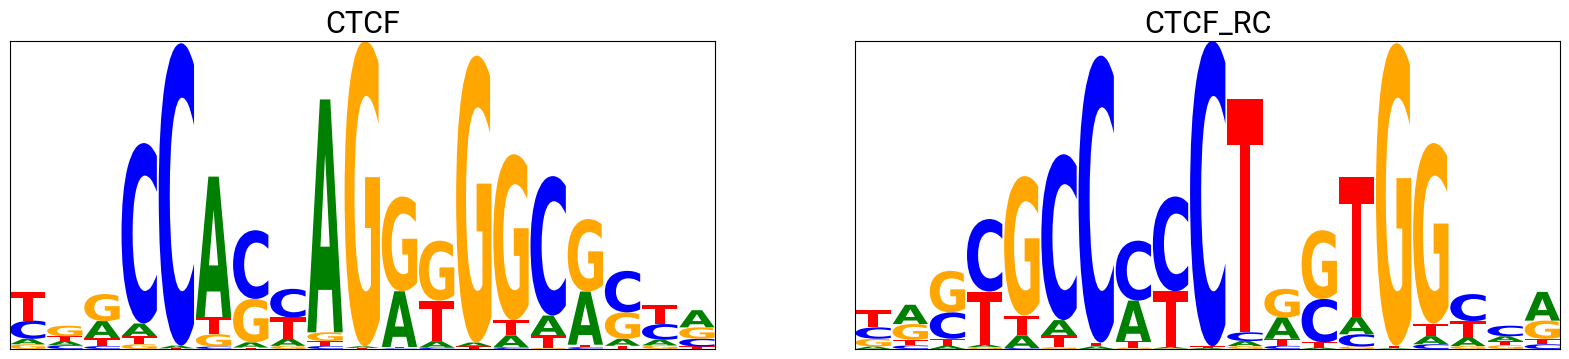

FOXA1 (HepG2)


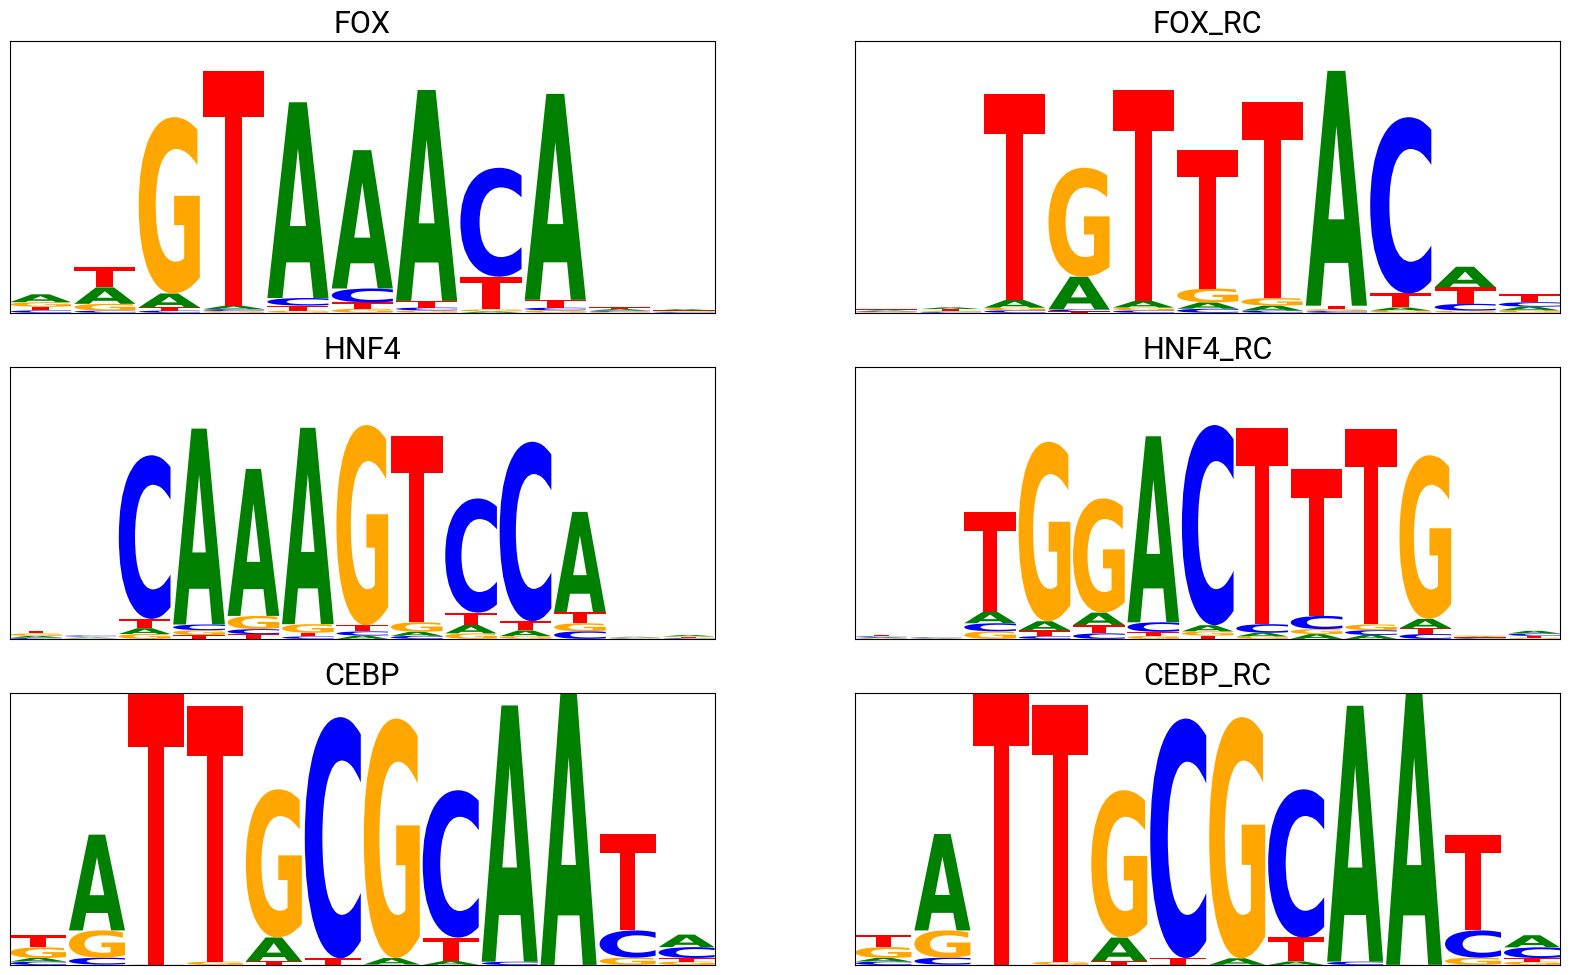

DNase (HepG2)


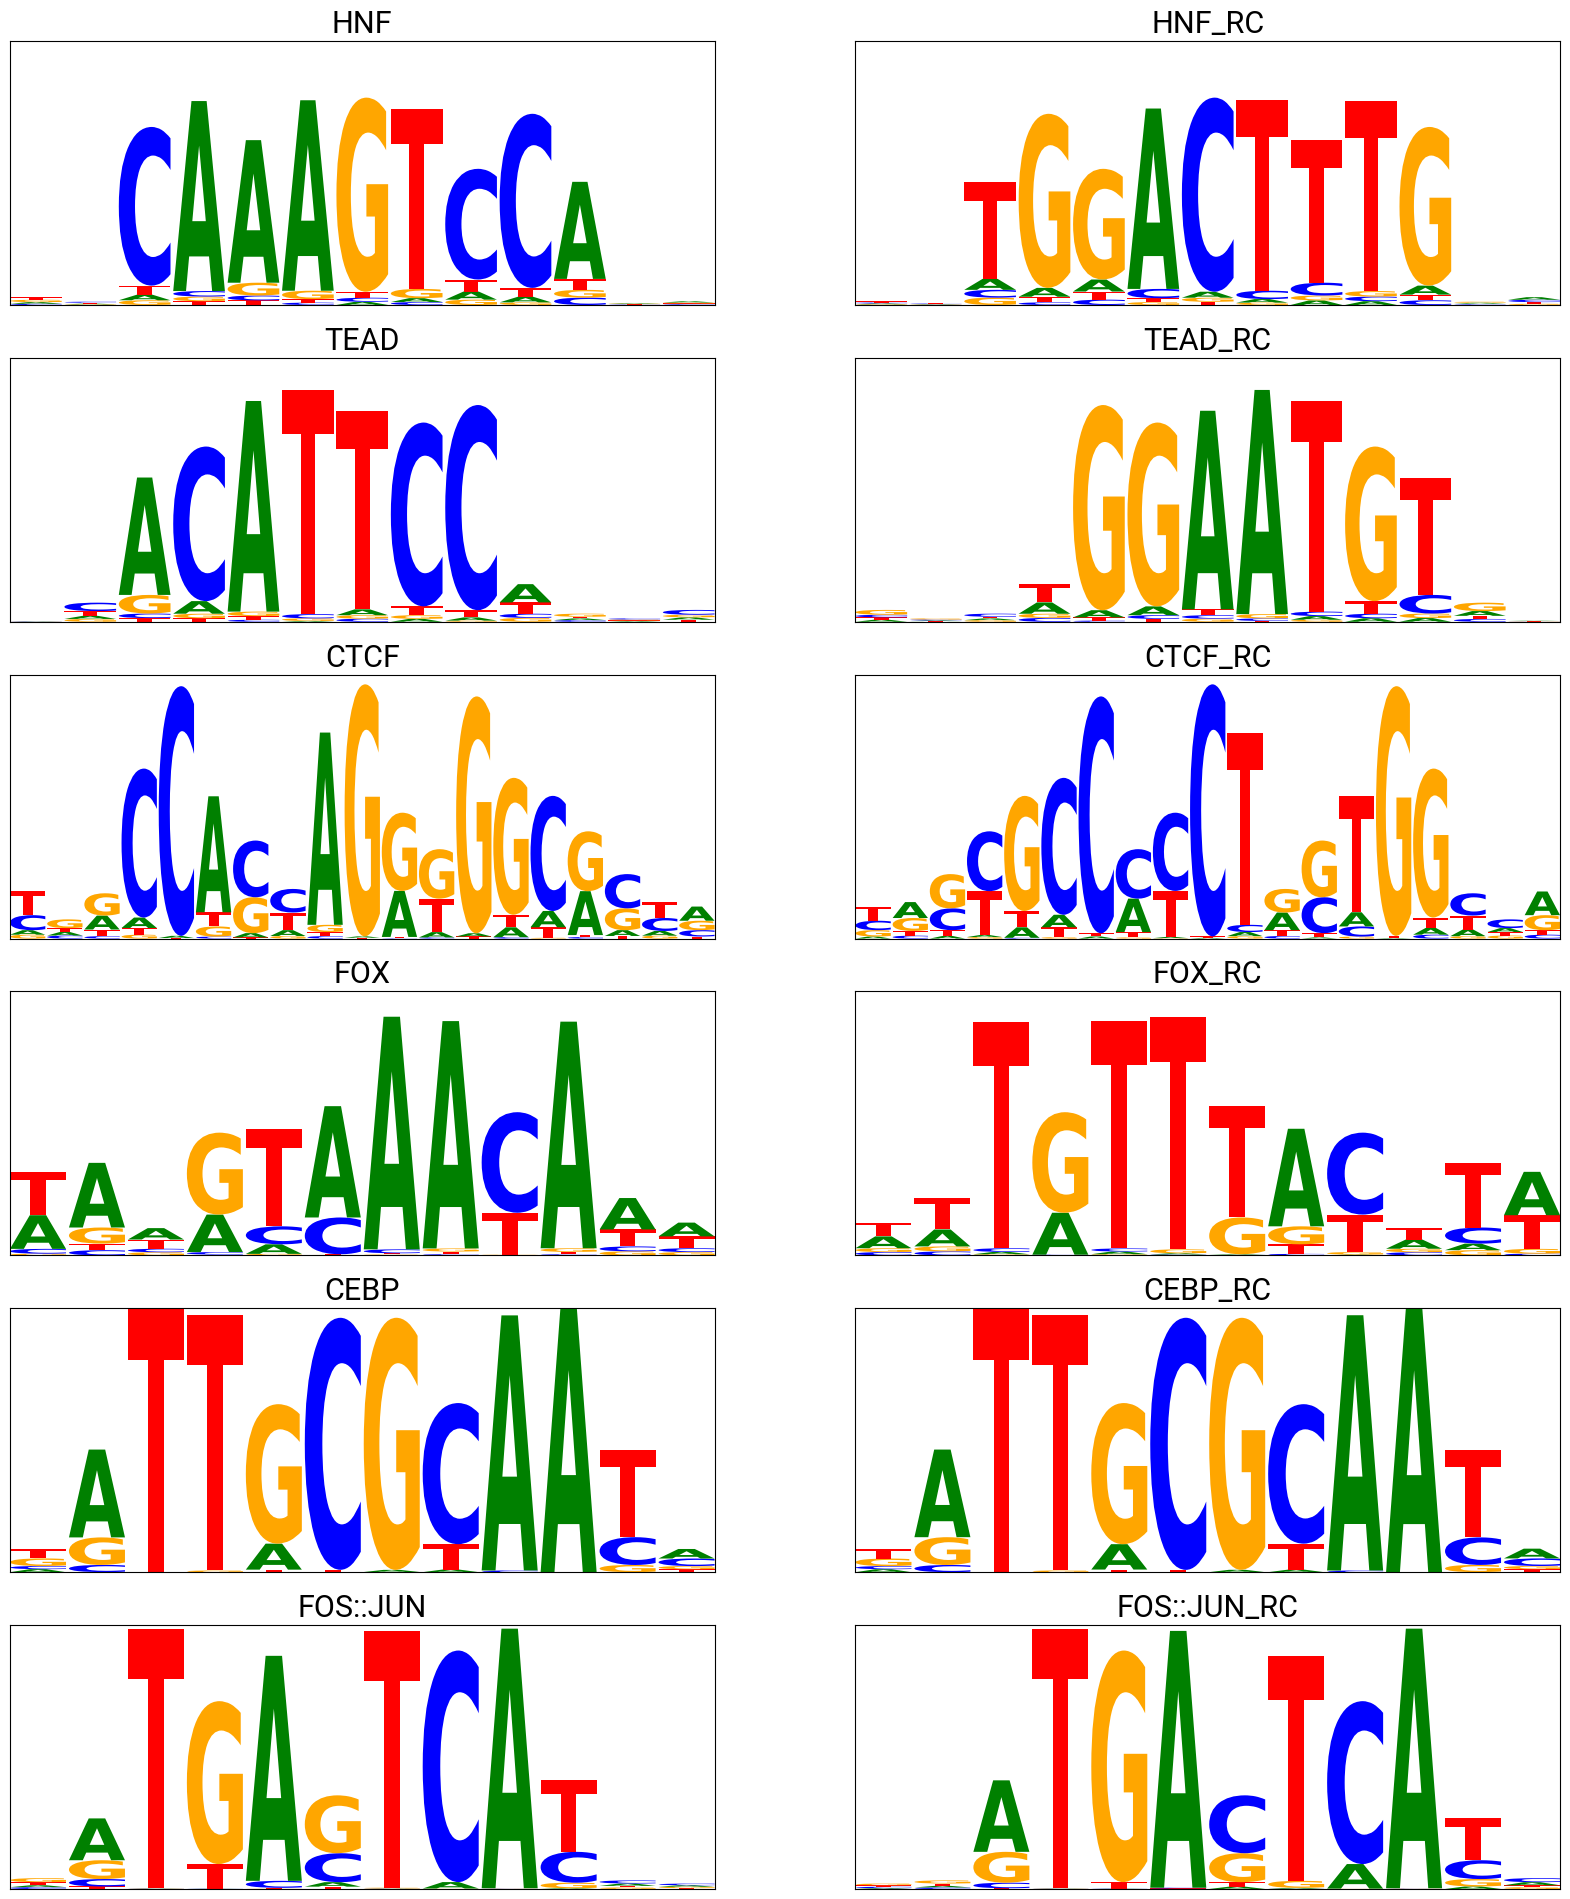

DNase (HL-60)


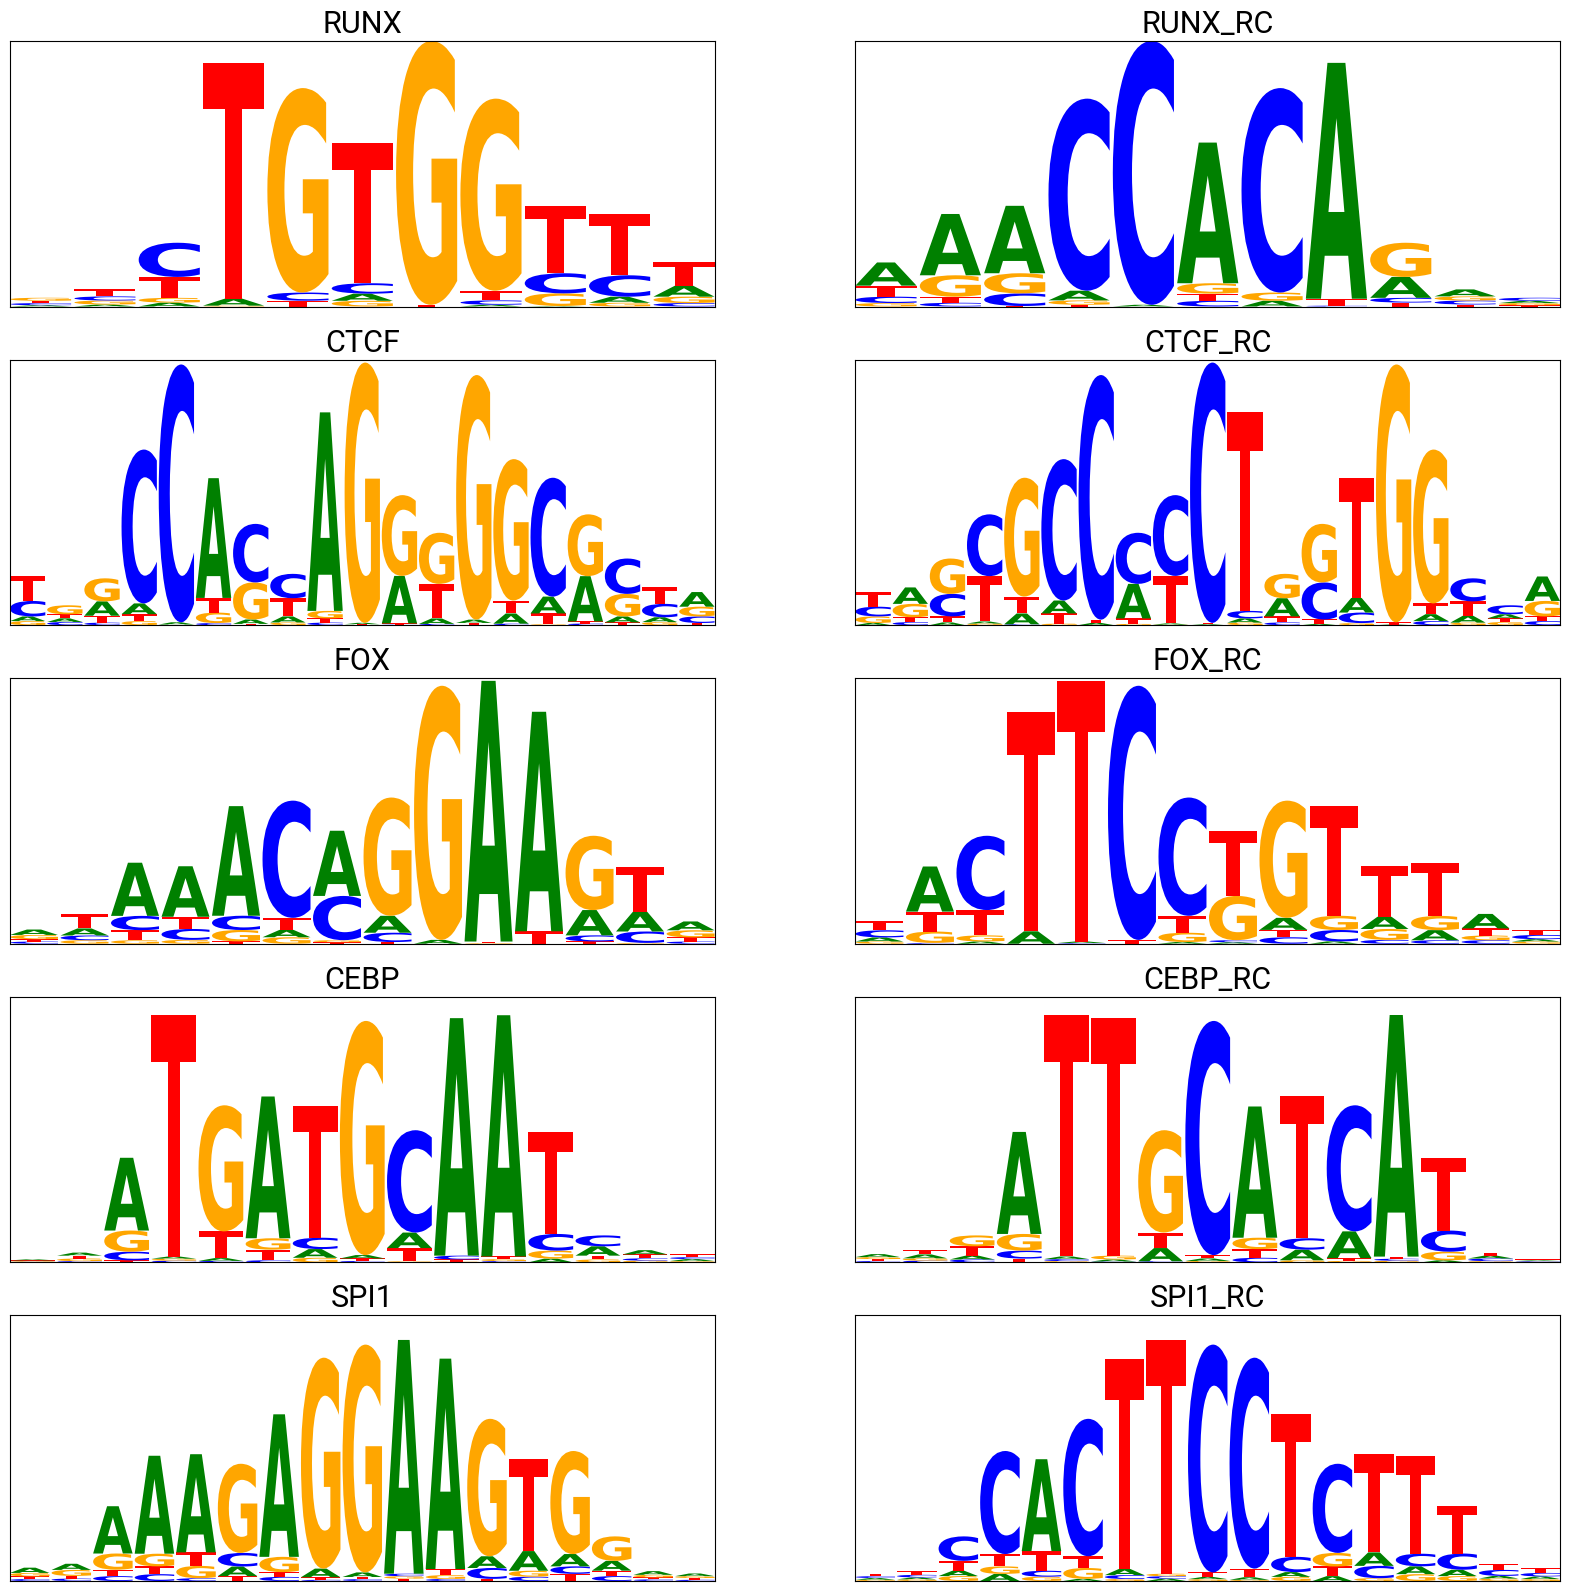

DNase (K562)


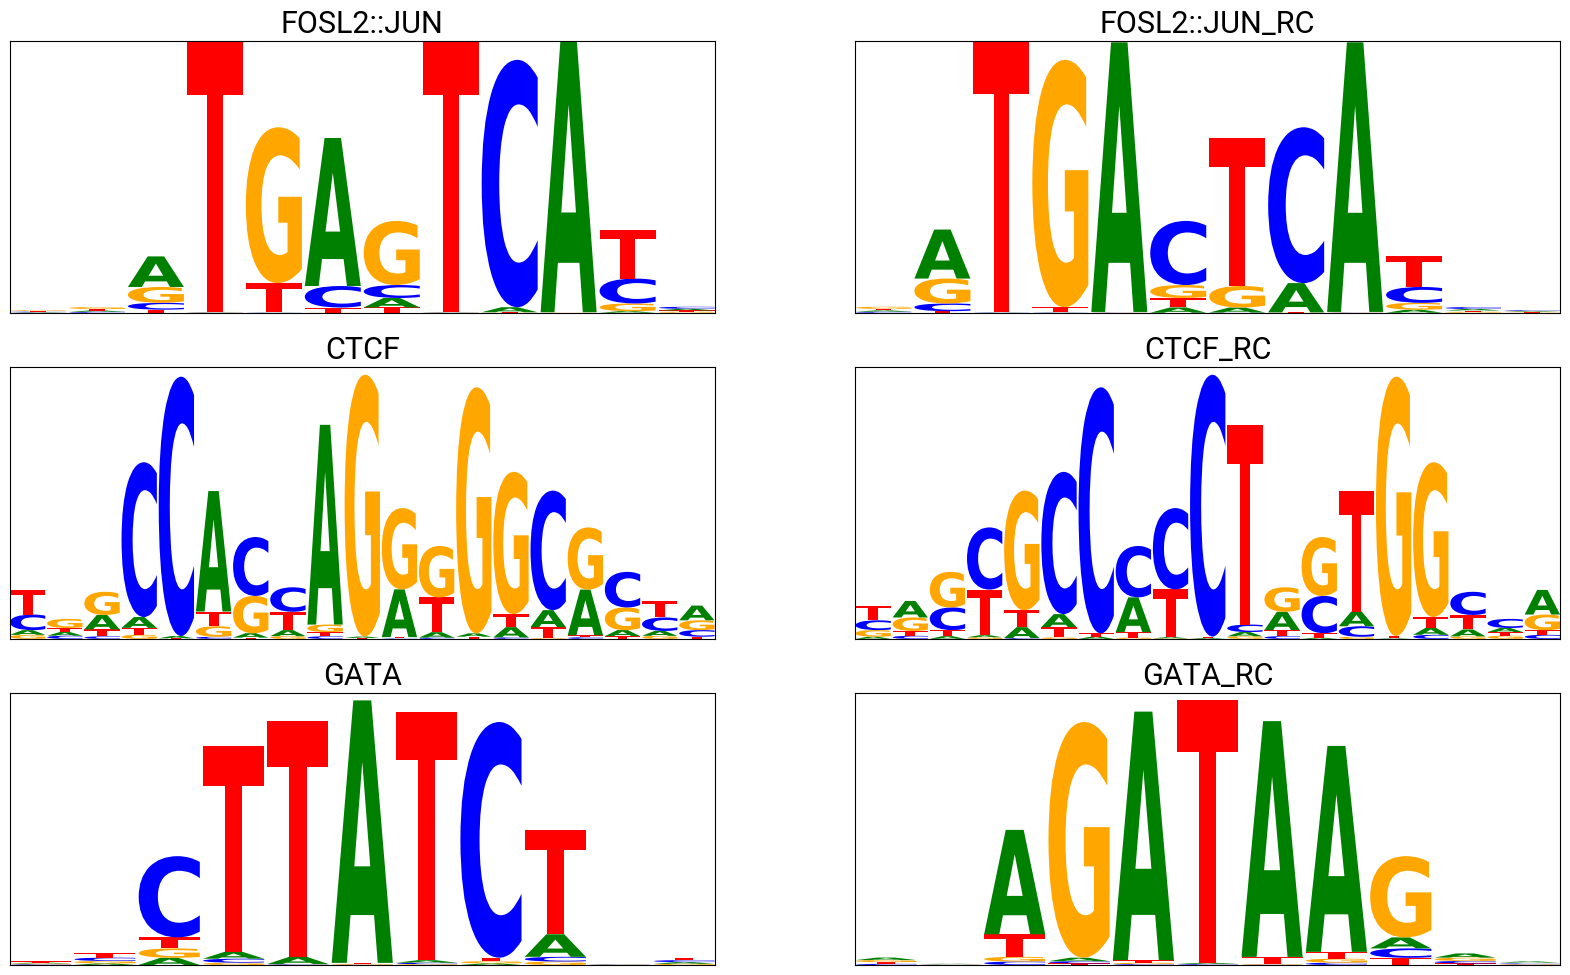

In [15]:
for dataset_key in datasets:
    print(dataset_key)
    motif_keys, pfms = zip(*pfms_to_plot[dataset_key].items())
    fig = plot_motifs.plot_motif_grid(
        [pfm * motif_util.pfm_info_content(pfm)[:, None] for pfm in pfms],
        titles=motif_keys,
        show_x=False, show_y=False
    )
    fig.savefig(os.path.join(figures_out_path, datasets_sanit[dataset_key] + "_true_motifs.svg"), format="svg")
    plt.show()